In [2]:
!pip install sentence-transformers matplotlib


In [3]:
from google.colab import drive

from huggingface_hub import notebook_login

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import openai

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk. tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from IPython.display import display


In [4]:
# Request access to drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Load the dataset
dataset = pd.read_csv('/content/drive/My Drive/Colab Notebooks/BERTopic/preprocessed_ai_jobs_subset_275.csv')

dataset

,job_id,company_name,title,description,original_listed_time,expiry,cleaned_description,cleaned_title
0,2269442456,navXcom,Computer Scientist,Are you passionate about developing cutting-ed...,2024-04-19 02:31:59,2024-05-19 02:31:59,passionate developing software deep space comm...,computer scientist
1,3245063922,Saxon AI,Data Architect,Request: Data ArchitectLocation: San Francisco...,2024-04-19 14:27:02,2024-05-19 14:27:02,request data architectlocation san francisco c...,data architect
2,3533320307,NLB Services,Java architect / Lead Java developer,Position: Java architect / Lead Java developer...,2024-04-11 17:08:59,2024-05-11 17:08:59,position java architect lead java developerloc...,java architect lead java developer
3,3586167732,StyleAI,Senior Software Engineer,"StyleAI is the AI-powered, all-in-one unified ...",2024-04-17 23:33:53,2024-05-17 23:33:53,styleai unified marketing platform business am...,senior software engineer
4,3728459637,HireBus,Principal Backend Engineer,Principal Backend Engineer - Join HireBus and ...,2024-04-18 20:04:36,2024-05-18 20:04:36,principal backend engineer join hirebus revolu...,principal backend engineer
...,...,...,...,...,...,...,...,...
2218,3906256303,Overview,Full Stack Engineer (San Fransisco),Company Overview\n\nOverview.ai is a leading i...,2024-04-19 22:49:16,2024-05-19 23:07:57,company overview leading innovator computer vi...,full stack engineer san fransisco
2219,3906257658,Accenture,SAP Program Delivery Lead - Aerospace & Defense,"We Are: \n\nAccenture’s SAP practice, and we b...",2024-04-19 23:13:36,2024-05-19 23:29:24,accenture sap practice bring new life using de...,sap program delivery lead aerospace defense
2220,3906259133,Scorebird,Embedded Software Engineer,"Senior Embedded Developer\n- BS degree in CS, ...",2024-04-19 22:53:01,2024-05-19 22:53:01,senior embedded developer b degree c ee relate...,embedded software engineer
2221,3906259147,Advantis Global is becoming INSPYR Solutions,Data Engineer II,About This Featured Opportunity\n\nWe are look...,2024-04-19 22:48:21,2024-05-19 22:59:36,featured opportunity looking data engineer occ...,data engineer ii


In [6]:
# Fill missing values in the "description" column with an empty string
dataset["cleaned_description"] = dataset["cleaned_description"].fillna("")

# Ensure all values are strings
dataset["cleaned_description"] = dataset["cleaned_description"].astype(str)

# Combine titles and descriptions into a single column
dataset["combined"] = dataset["cleaned_title"] + " " + dataset["cleaned_description"]

# Convert combined column to a list
titles = dataset["cleaned_title"]
description = dataset["cleaned_description"]
combined = dataset["combined"].astype(str)

# Preview an entry
print(f"Example combined entry: {dataset['combined'].iloc[0]}")

Example combined entry: computer scientist passionate developing software deep space communication navigation system ready jumpstart career become part core team exciting opportunity seeking talented computer scientist voluntary unpaid basis join dynamic team contribute creation innovative mobile application support nasa collaborate talented team engineer software developer product manager turn idea secured software


In [7]:
baseline_competences = [
    "Knowledge representation and reasoning",
    "Automated planning and scheduling",
    "Machine learning",
    "Natural language processing",
    "Machine perception",
    "Computer vision",
    "Speech recognition",
    "Robotics",
    "Affective computing",
    "Deep learning",
    "Information retrieval",
    "Computer science",
    "Causality",
    "Data mining",
    "Commonsense knowledge",
    "Intelligent agents",
    "Generative AI",
    "Large Language Models",
    "AI decision making"
]

In [8]:
edison_competences = {
    "DSDA": {
        "DSDA01": "Use various data analytics techniques like machine learning (supervised, unsupervised, and semi-supervised learning), data mining, and predictive analytics.",
        "DSDA02": "Apply quantitative techniques, such as statistics, time series analysis, optimization, and simulation, for model development.",
        "DSDA03": "Integrate heterogeneous data from different sources, such as social media, open data, and government data.",
        "DSDA04": "Validate models using performance and accuracy metrics.",
        "DSDA05": "Integrate analytics into workflows for agile decision-making.",
        "DSDA06": "Visualize and communicate insights using dashboards and storytelling methods."
    },
    "DSENG": {
        "DSENG01": "Design and develop tools for data collection, storage, analysis, and visualization.",
        "DSENG02": "Use data-driven solutions on platforms, especially for large datasets and cloud-based systems.",
        "DSENG03": "Prototype specialized data analysis applications for workflows.",
        "DSENG04": "Operate and maintain large-scale storage and distributed processing platforms.",
        "DSENG05": "Implement data security mechanisms for privacy and intellectual property rights.",
        "DSENG06": "Design relational and non-relational databases and support ETL (Extract, Transform, Load) processes."
    },
    "DSDM": {
        "DSDM01": "Develop and implement a data management strategy, including policies.",
        "DSDM02": "Create and manage metadata for different types of data.",
        "DSDM03": "Combine data from multiple sources for analysis.",
        "DSDM04": "Maintain data provenance to track its history and use.",
        "DSDM05": "Ensure data quality, accessibility, and compliance.",
        "DSDM06": "Manage data protection, privacy, and ethics-related issues."
    },
    "DSRMP": {
        "DSRMP01": "Employ research methods like hypothesis testing and artifact evaluation.",
        "DSRMP02": "Conduct systematic investigations to meet organizational or research objectives.",
        "DSRMP03": "Analyze research models and identify relevant data for hypothesis formulation.",
        "DSRMP04": "Use innovative methods to revise or expand organizational objectives.",
        "DSRMP05": "Design experiments, collect data, and test hypotheses effectively.",
        "DSRMP06": "Plan and manage data-driven projects, covering risk, quality, and team management."
    },
    "DSDK": {
        "DSDK01": "Apply domain-specific knowledge to develop relevant data analysis tools.",
        "DSDK02": "Tailor general methods to domain-specific data types and processes.",
        "DSDK03": "Present domain-specific data models and findings effectively.",
        "DSDK04": "Use knowledge to solve domain-specific problems.",
        "DSDK05": "Develop advanced analytics tools specific to the domain.",
        "DSDK06": "Combine domain expertise with general analytical methods for unique insights."
    }

}


In [9]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [10]:
# Preprocessing function for text
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    # Tokenize and clean text
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words]

    return ' '.join(tokens)


# Apply preprocessing to the competence descriptions
print("Preprocessing competences...")
preprocessed_edison_competences = {
    group: {code: preprocess_text(description) for code, description in descriptions.items()}
    for group, descriptions in edison_competences.items()
}


# Print a sample of the preprocessed competences
for group, descriptions in preprocessed_edison_competences.items():
    print(f"Group: {group}")
    for code, cleaned_text in descriptions.items():
        print(f"  {code}: {cleaned_text}")
    break

Preprocessing competences...
Group: DSDA
  DSDA01: use various data analytics technique like machine learning supervised unsupervised learning data mining predictive analytics
  DSDA02: apply quantitative technique statistic time series analysis optimization simulation model development
  DSDA03: integrate heterogeneous data different source social medium open data government data
  DSDA04: validate model using performance accuracy metric
  DSDA05: integrate analytics workflow agile
  DSDA06: visualize communicate insight using dashboard storytelling method


In [11]:
# embedding model
models = {"E5-large": SentenceTransformer("intfloat/e5-large-v2")}

# Pre-calculate embeddings for job postings
job_postings_embeddings = {
    model_name: model.encode(combined, convert_to_numpy=True, show_progress_bar=True)
    for model_name, model in models.items()
}

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/67.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

Batches:   0%|          | 0/70 [00:00<?, ?it/s]

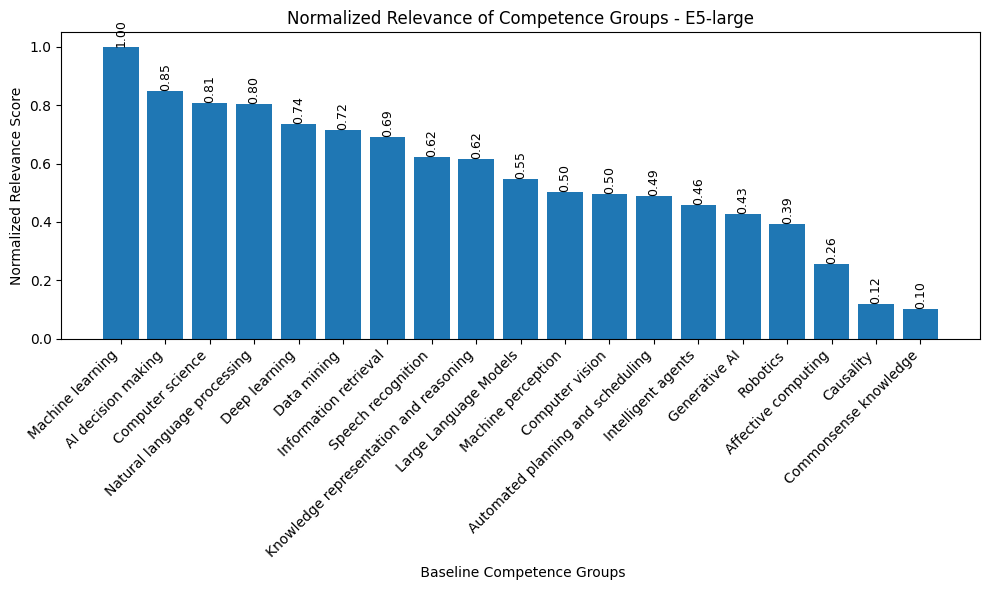

In [12]:
# BASELINE COMPETENCE GROUPS

# Generate embeddings for competences
competences_embeddings = {
    model_name: {
        competence: model.encode(competence, convert_to_numpy=True)
        for competence in baseline_competences
    }
    for model_name, model in models.items()
}

# Compute similarity scores
similarity_scores = {
    model_name: {
        competence: cosine_similarity(job_postings_embeddings[model_name],
                                       np.array([embedding])).flatten()
        for competence, embedding in competence_embeddings.items()
    }
    for model_name, competence_embeddings in competences_embeddings.items()
}

# Aggregate results and rank competences for each job posting
ranked_scores = {
    model_name: {
        job_idx: sorted(
            [(competence, scores[job_idx]) for competence, scores in model_scores.items()],
            key=lambda x: x[1],
            reverse=True
        )
        for job_idx in range(job_postings_embeddings[model_name].shape[0])
    }
    for model_name, model_scores in similarity_scores.items()
}

# Compute average scores for each competence group
avg_scores = {
    model_name: {
        competence: np.mean(scores)
        for competence, scores in model_scores.items()
    }
    for model_name, model_scores in similarity_scores.items()
}

# Normalize scores to a scale of 1 to 0.1
def normalize_scores(scores, min_value=0.1, max_value=1.0):
    min_score = min(scores.values())
    max_score = max(scores.values())
    return {key: min_value + (value - min_score) * (max_value - min_value) / (max_score - min_score)
            for key, value in scores.items()}

for model_name, scores in avg_scores.items():
    # Normalize the scores
    normalized_scores = normalize_scores(scores, min_value=0.1, max_value=1.0)

    # Sort normalized scores for plotting
    sorted_scores = dict(sorted(normalized_scores.items(), key=lambda x: x[1], reverse=True))

    # Plot the scores
    plt.figure(figsize=(10, 6))
    plt.bar(sorted_scores.keys(), sorted_scores.values())
    plt.xlabel(" Baseline Competence Groups")
    plt.ylabel("Normalized Relevance Score")
    plt.title(f"Normalized Relevance of Competence Groups - {model_name}")
    plt.xticks(rotation=45, ha="right")

    # Annotate bars with normalized scores
    for i, (key, value) in enumerate(sorted_scores.items()):
        plt.text(i, value, f"{value:.2f}", ha='center', va='bottom', fontsize=9, rotation=90)

    plt.tight_layout()
    plt.show()

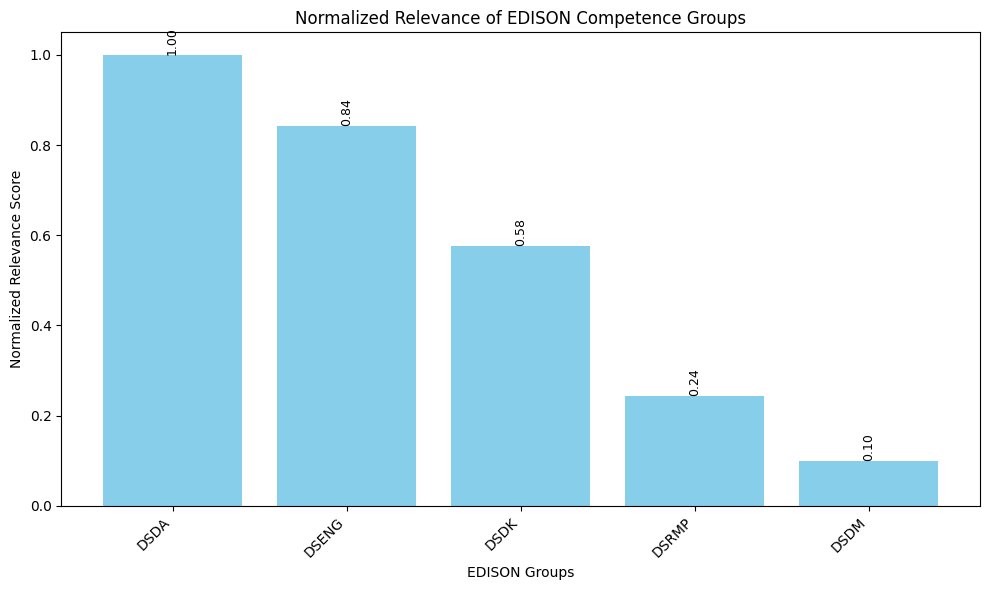

In [13]:
# Generate embeddings for EDISON competences
edison_embeddings = {
    group: {
        code: models["E5-large"].encode(description, convert_to_numpy=True)
        for code, description in descriptions.items()
    }
    for group, descriptions in preprocessed_edison_competences.items()
}

# Aggregate subcompetence embeddings to group-level embeddings
edison_group_embeddings = {
    group: np.mean(list(subcompetence_embeddings.values()), axis=0)
    for group, subcompetence_embeddings in edison_embeddings.items()
}

# Compute similarity scores between job postings and EDISON groups
edison_similarity_scores = {
    group: cosine_similarity(job_postings_embeddings["E5-large"], np.array([embedding])).flatten()
    for group, embedding in edison_group_embeddings.items()
}

# Compute average and normalized scores for EDISON groups
# Average scores
avg_edison_scores = {
    group: np.mean(scores)
    for group, scores in edison_similarity_scores.items()
}

# Normalize scores to a scale of 1 to 0.1
normalized_edison_scores = normalize_scores(avg_edison_scores, min_value=0.1, max_value=1.0)

# Sort normalized scores for visualization
sorted_edison_scores = dict(sorted(normalized_edison_scores.items(), key=lambda x: x[1], reverse=True))

# Visualize EDISON group relevance
plt.figure(figsize=(10, 6))
plt.bar(sorted_edison_scores.keys(), sorted_edison_scores.values(), color="skyblue")
plt.xlabel("EDISON Groups")
plt.ylabel("Normalized Relevance Score")
plt.title("Normalized Relevance of EDISON Competence Groups")
plt.xticks(rotation=45, ha="right")

# Annotate bars with normalized scores
for i, (key, value) in enumerate(sorted_edison_scores.items()):
    plt.text(i, value, f"{value:.2f}", ha='center', va='bottom', fontsize=9, rotation=90)

plt.tight_layout()
plt.show()

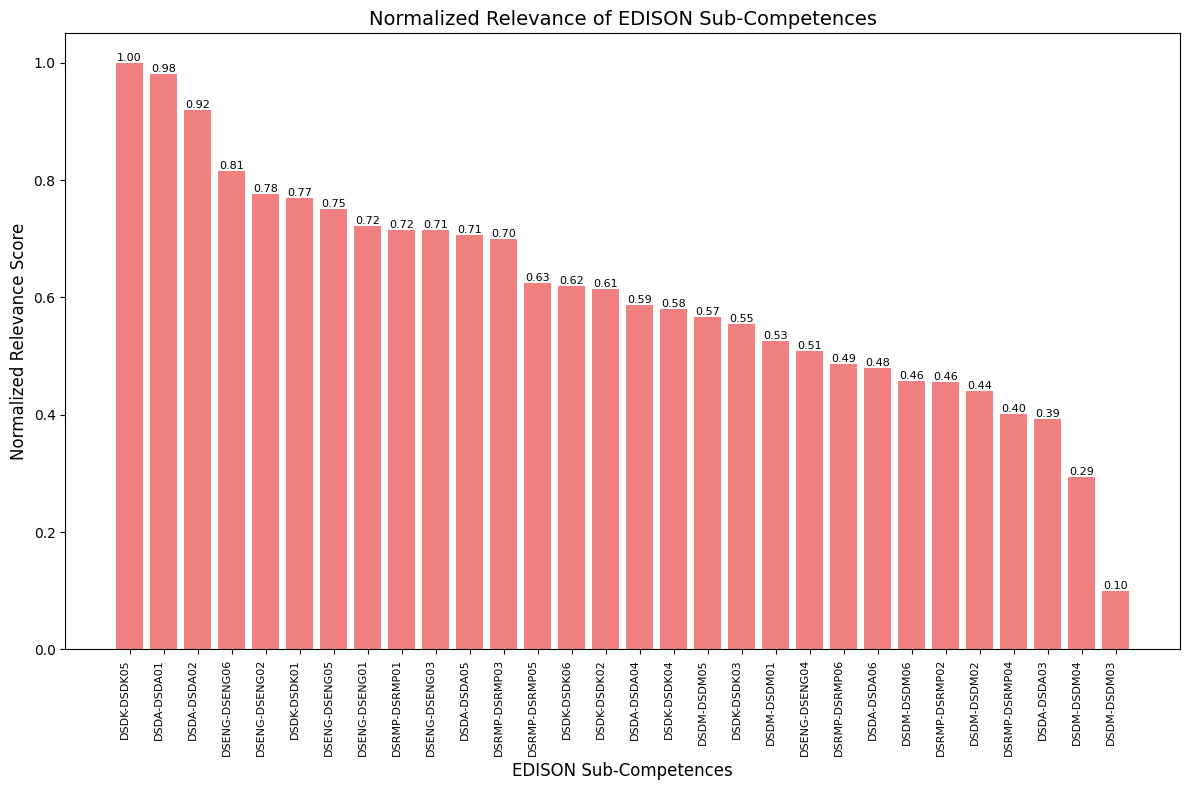

In [14]:
# Generate embeddings for each EDISON sub-competence
edison_subcompetence_embeddings = {
    f"{group}-{code}": models["E5-large"].encode(description, convert_to_numpy=True)
    for group, descriptions in preprocessed_edison_competences.items()
    for code, description in descriptions.items()
}

# Compute similarity scores for each sub-competence
edison_subcompetence_similarity_scores = {
    subcompetence: cosine_similarity(job_postings_embeddings["E5-large"], np.array([embedding])).flatten()
    for subcompetence, embedding in edison_subcompetence_embeddings.items()
}

# Average scores for each sub-competence
avg_subcompetence_scores = {
    subcompetence: np.mean(scores)
    for subcompetence, scores in edison_subcompetence_similarity_scores.items()
}

# Normalize scores
normalized_subcompetence_scores = normalize_scores(avg_subcompetence_scores, min_value=0.1, max_value=1.0)

# Sort scores for visualization
sorted_subcompetence_scores = dict(sorted(normalized_subcompetence_scores.items(), key=lambda x: x[1], reverse=True))

# Visualize normalized relevance scores for sub-competences
plt.figure(figsize=(12, 8))
plt.bar(sorted_subcompetence_scores.keys(), sorted_subcompetence_scores.values(), color="lightcoral")
plt.xlabel("EDISON Sub-Competences", fontsize=12)
plt.ylabel("Normalized Relevance Score", fontsize=12)
plt.title("Normalized Relevance of EDISON Sub-Competences", fontsize=14)
plt.xticks(rotation=90, fontsize=8, ha="right")

# Annotate bars with scores
for i, (key, value) in enumerate(sorted_subcompetence_scores.items()):
    plt.text(i, value, f"{value:.2f}", ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

In [15]:
# Mapping baseline competences to EDISON groups
mapping_scores = {
    baseline: {
        edison_group: cosine_similarity(
            np.array([competences_embeddings["E5-large"][baseline]]),  # Baseline competence embedding
            np.array([edison_group_embeddings[edison_group]])  # EDISON group embedding
        ).flatten()[0]
        for edison_group in edison_group_embeddings
    }
    for baseline in competences_embeddings["E5-large"]
}

# Find the best-aligned EDISON group for each baseline competence
best_mapping = {baseline: max(scores, key=scores.get) for baseline, scores in mapping_scores.items()}

# Mapping of EDISON group abbreviations to their full names
broader_group_mapping = {
    "DSDA": "Data Science Analytics",
    "DSENG": "Data Science Engineering",
    "DSDM": "Data Management",
    "DSRMP": "Research Methods and Project Management",
    "DSDK": "Domain Knowledge and Expertise"
}

# Prepare the data for the DataFrame
table_data_baseline_to_edison = []

# Iterate over baseline competences and their mappings to EDISON groups
for baseline, scores in mapping_scores.items():
    best_group = max(scores, key=scores.get)  # Find the best EDISON group for this baseline
    best_score = scores[best_group]          # Get the corresponding score
    full_name_group = broader_group_mapping[best_group]  # Convert abbreviation to full name
    table_data_baseline_to_edison.append({
        "Baseline Competence": baseline,
        "EDISON Competence": full_name_group,
        "Cosine Similarity": round(best_score, 2)
    })

# Create a DataFrame
df_baseline_to_edison = pd.DataFrame(table_data_baseline_to_edison)

# Display the DataFrame
print("Baseline Competence Mapping to Broader EDISON Groups")
display(df_baseline_to_edison)


Baseline Competence Mapping to Broader EDISON Groups


,Baseline Competence,EDISON Competence,Cosine Similarity
0,Knowledge representation and reasoning,Domain Knowledge and Expertise,0.87
1,Automated planning and scheduling,Domain Knowledge and Expertise,0.84
2,Machine learning,Data Science Analytics,0.87
3,Natural language processing,Data Science Analytics,0.85
4,Machine perception,Data Science Analytics,0.84
5,Computer vision,Data Science Analytics,0.83
6,Speech recognition,Data Science Analytics,0.83
7,Robotics,Data Science Analytics,0.82
8,Affective computing,Data Science Analytics,0.83
9,Deep learning,Data Science Analytics,0.85


In [16]:
# Mapping baseline competences to EDISON sub-competences
subcompetence_mapping_scores = {
    baseline: {
        subcompetence: cosine_similarity(
            np.array([competences_embeddings["E5-large"][baseline]]),  # Baseline competence embedding
            np.array([edison_embeddings[group][subcompetence]])  # EDISON sub-competence embedding
        ).flatten()[0]
        for group, subcompetences in edison_embeddings.items()
        for subcompetence in subcompetences
    }
    for baseline in competences_embeddings["E5-large"]
}

# Reverse the mapping to find the best baseline for each subcompetence
subcompetence_to_baseline = {}
for baseline, scores in subcompetence_mapping_scores.items():
    for subcompetence, score in scores.items():
        if subcompetence not in subcompetence_to_baseline or score > subcompetence_to_baseline[subcompetence]["score"]:
            subcompetence_to_baseline[subcompetence] = {"baseline": baseline, "score": score}

# Prepare the data for the DataFrame
table_data = []
broader_group_mapping = {
    "DSDA": "Data Science Analytics",
    "DSENG": "Data Science Engineering",
    "DSDM": "Data Management",
    "DSRMP": "Research Methods and Project Management",
    "DSDK": "Domain Knowledge and Expertise"
}

# Iterate over the broader groups and their subcompetences
for group, subcompetences in edison_embeddings.items():
    broader_group = broader_group_mapping[group]
    for subcompetence in subcompetences:
        if subcompetence in subcompetence_to_baseline:
            mapping = subcompetence_to_baseline[subcompetence]
            baseline = mapping["baseline"]
            score = mapping["score"]
            table_data.append({
                "EDISON Competence": broader_group,
                "EDISON Sub-Competence": subcompetence,
                "Baseline Competence": baseline,
                "Cosine Similarity": round(score, 2),
            })

# Create a DataFrame
df = pd.DataFrame(table_data)


# Display the DataFrame in Jupyter or Colab
print("Edison sub-competence group with highest baseline competence group similarity")
display(df)

Edison sub-competence group with highest baseline competence group similarity


,EDISON Competence,EDISON Sub-Competence,Baseline Competence,Cosine Similarity
0,Data Science Analytics,DSDA01,Machine learning,0.85
1,Data Science Analytics,DSDA02,Machine learning,0.80
2,Data Science Analytics,DSDA03,Data mining,0.78
3,Data Science Analytics,DSDA04,Machine learning,0.79
4,Data Science Analytics,DSDA05,AI decision making,0.79
5,Data Science Analytics,DSDA06,Knowledge representation and reasoning,0.79
6,Data Science Engineering,DSENG01,Data mining,0.81
7,Data Science Engineering,DSENG02,Large Language Models,0.81
8,Data Science Engineering,DSENG03,AI decision making,0.79
9,Data Science Engineering,DSENG04,Natural language processing,0.79


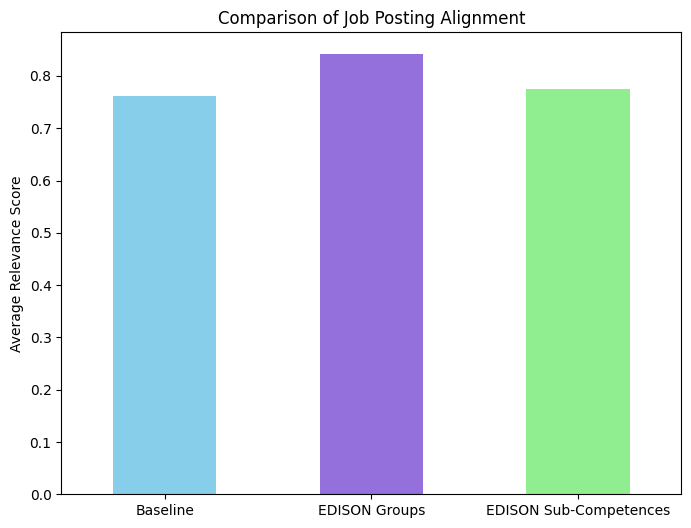

In [17]:
# Compare aggregated alignment for job postings
# Average alignment score of baseline competences for each job posting
baseline_posting_scores = np.mean([
    cosine_similarity(job_postings_embeddings["E5-large"], np.array([embedding])).flatten()
    for embedding in competences_embeddings["E5-large"].values()
], axis=0)

# Average alignment score of EDISON groups for each job posting
edison_group_posting_scores = np.mean([
    cosine_similarity(job_postings_embeddings["E5-large"], np.array([embedding])).flatten()
    for embedding in edison_group_embeddings.values()
], axis=0)

# Average alignment score of EDISON sub-competences for each job posting
edison_sub_posting_scores = np.mean([
    cosine_similarity(job_postings_embeddings["E5-large"], np.array([embedding])).flatten()
    for group, subcompetences in edison_embeddings.items()
    for embedding in subcompetences.values()
], axis=0)

# Combine scores into a single dataframe for visualization
comparison_data = pd.DataFrame({
    "Baseline": baseline_posting_scores,
    "EDISON Groups": edison_group_posting_scores,
    "EDISON Sub-Competences": edison_sub_posting_scores
})

# Plot comparison
comparison_data.mean().plot(kind="bar", figsize=(8, 6), color=["skyblue", "mediumpurple", "lightgreen"])
plt.ylabel("Average Relevance Score")
plt.title("Comparison of Job Posting Alignment")
plt.xticks(rotation=0)
plt.show()

In [20]:
import plotly.graph_objects as go

# Extract unique nodes (Baseline Competence and EDISON Competence)
nodes = list(df_baseline_to_edison["Baseline Competence"].unique()) + list(df_baseline_to_edison["EDISON Competence"].unique())

# Create a mapping from node names to indices
node_indices = {node: idx for idx, node in enumerate(nodes)}

# Prepare the source, target, and weight for the Sankey diagram
source = df_baseline_to_edison["Baseline Competence"].map(node_indices).tolist()
target = df_baseline_to_edison["EDISON Competence"].map(node_indices).tolist()
value = df_baseline_to_edison["Cosine Similarity"].tolist()

# Create the Sankey diagram
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=nodes
    ),
    link=dict(
        source=source,
        target=target,
        value=value
    )
))

# Add title and show the figure
fig.update_layout(
    title_text="Sankey Diagram of Baseline Competences to EDISON Groups",
    font_size=10
)
fig.show()

In [26]:
import plotly.graph_objects as go

# Extract unique nodes
broad_groups = list(df["EDISON Competence"].unique())  # Broader EDISON groups
baseline_groups = list(df["Baseline Competence"].unique())  # Baseline competences
sub_competences = list(df["EDISON Sub-Competence"].unique())  # EDISON sub-competences

# Combine all nodes into a single list
nodes = broad_groups + baseline_groups + sub_competences

# Create a mapping from node names to indices
node_indices = {node: idx for idx, node in enumerate(nodes)}

# Define the source, target, and weight for each link
# 1. Links from EDISON broad groups to baseline competences
source_broad_to_baseline = df["EDISON Competence"].map(node_indices).tolist()
target_broad_to_baseline = df["Baseline Competence"].map(node_indices).tolist()
value_broad_to_baseline = df["Cosine Similarity"].tolist()

# 2. Links from baseline competences to EDISON sub-competences
source_baseline_to_sub = df["Baseline Competence"].map(node_indices).tolist()
target_baseline_to_sub = df["EDISON Sub-Competence"].map(node_indices).tolist()
value_baseline_to_sub = df["Cosine Similarity"].tolist()

# Combine sources, targets, and values
source = source_broad_to_baseline + source_baseline_to_sub
target = target_broad_to_baseline + target_baseline_to_sub
value = value_broad_to_baseline + value_baseline_to_sub


# Create the Sankey diagram
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=nodes
    ),
    link=dict(
        source=source,
        target=target,
        value=value
    )
))

# Add title and show the figure
fig.update_layout(
    title_text="EDISON Groups <-> Baseline Competences <-> EDISON Sub-Competences",
    font_size=10
)
fig.show()


In [ ]:
# Baseline competences that do not have a significantly high similarity to EDISON sub groups:
# Computer science, Deep learning, speech recognition, machine perception, computer vision, intelligent agents, robotics, affective computing, causality